In [12]:
import numpy as np
import csv
from Library import Convert_to_A_and_B, ka, truncate, Create_MPO, Pauli, Model_coefficients, Entropy

def H_mult(v):
    return np.matmul(H,v)

def Create_random_MPS(L, chis, d=2):
    Gamma,v = [],[[1.]]
    for m in range (L):
       Gamma.append((np.random.rand(chis[m],d,chis[m+1])+1j*np.random.rand(chis[m],d,chis[m+1])))
       norm = np.einsum("aib,aib->",Gamma[m],np.conj(Gamma[m]))
       Gamma[m] = Gamma[m]/np.sqrt(norm)
       v.append(np.random.rand(chis[m+1]))
       v_norm = np.linalg.norm(v[m+1])
       v[m+1] = v[m+1]/v_norm
    return Gamma,v
def Magnetisation(B,L, S):
  #v_L,v_R = np.zeros(chi_MPO,dtype=np.complex_), np.zeros(chi_MPO,dtype=np.complex_)
  v_L,v_R=np.array([[1.+0j]]),np.array([[1.+0j]])
  Env = v_L
  
  for j in range(1,L+1):
    Env = np.einsum("ac,aid->dic",Env,B[j])
    Env = np.einsum("dic,ij->djc",Env,S)
    Env = np.einsum("djc,cjf->df",Env,np.conj(B[j]))
  Magnet = np.einsum("da,da->",Env,v_R)
  return Magnet.real


def Exp_value_B(B, L, W, chi_MPO):
  v_L,v_R = np.zeros(chi_MPO,dtype=np.complex_), np.zeros(chi_MPO,dtype=np.complex_)
  v_L[0],v_R[-1]=1.+0j, 1.+0j
  Env = np.einsum("a,b,c->abc",B[0],v_L,B[0])
  
  for j in range(1,L+1):
    Env = np.einsum("abc,ajd->djbc",Env,B[j])
    Env = np.einsum("djbc,beji->deic",Env,W)
    Env = np.einsum("deic,cif->def",Env,np.conj(B[j]))
  Energy = np.einsum("ded,e->",Env,v_R)
  return Energy.real
def Magnetz(B, L, S,Lam):
    Maga = np.einsum("a,aib->aib",Lam[L//2-1],B[L//2])
    Maga = np.einsum("aib,ij->ajb",Maga,S)
    Laga = np.einsum("a,ajb->ajb",Lam[L//2-1],np.conj(B[L//2]))
    Mag = np.einsum("ajb,ajb->",Maga,Laga).real
    return Mag
def magnetz_sum(B, L, S,Lam):
  Mal = 0.
  for j in range(L):
    Maga = np.einsum("a,aib->aib",Lam[j],B[j+1])
    Maga = np.einsum("aib,ij->ajb",Maga,S)
    Laga = np.einsum("a,ajb->ajb",Lam[j],np.conj(B[j+1]))
    Mal += np.einsum("ajb,ajb->",Maga,Laga).real
  return Mal/L
def antif_order(B, L, S,Lam):
  Mal = 0.
  for j in range(L):
    Maga = np.einsum("a,aib->aib",Lam[j],B[j+1])
    Maga = np.einsum("aib,ij->ajb",Maga,S)
    Laga = np.einsum("a,ajb->ajb",Lam[j],np.conj(B[j+1]))
    Mal += ((-1)**(j+1))*np.einsum("ajb,ajb->",Maga,Laga).real
  return Mal/L
def Ferromagnetic_state(chi,L,d):
   Gamma = []
   lamba = [np.array([1.])]
   for j in range(L):
    Gamma.append(np.zeros((chi[j],d,chi[j+1])).astype(complex))
    Gamma[j][0,0,0]=1.+0j
    dui = np.zeros(chi[j+1])
    dui[0] = 1.
    lamba.append(dui)
   return Gamma,lamba
def Antiferromagnet_X(chi,L,d):
   Gamma = []
   lamba = [np.array([1.])]
   for j in range(L):
    if j%2==0:
     Gamma.append(np.zeros((chi[j],d,chi[j+1])).astype(complex))
     Gamma[j][0,0,0]=1./np.sqrt(2)+0j
     Gamma[j][0,1,0]=1./np.sqrt(2)+0j
     dui = np.zeros(chi[j+1])
     dui[0] = 1.
     lamba.append(dui)
    else:
     Gamma.append(np.zeros((chi[j],d,chi[j+1])).astype(complex))
     Gamma[j][0,0,0]=1./np.sqrt(2)+0j
     Gamma[j][0,1,0]=-1./np.sqrt(2)+0j
     dui = np.zeros(chi[j+1])
     dui[0] = 1.
     lamba.append(dui)
   return Gamma,lamba


In [13]:
from numpy import linalg as LA
from quspin.basis import spin_basis_1d 
from quspin.operators import hamiltonian # Hamiltonians and operators
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import LinearOperator
import matplotlib.pyplot as plt

data_type=np.complex128
S_z, S_x, S_y, S1 = Pauli()

d = 2
L = 80     # system size
chi_max = 2         # Maximal bond dimension       
#n = 10   # Number of zips
h_x, h_y, h_z = 0., 0.9, 0.  # Field in the different directions
J_xx, J_yy, J_zz = 1., 1.2, 1  # Strength of spin interactions
Model = [["x"],["z"]]     # The first part of the model gives us the spin interaction and the second one the fields
chi_MPO = len(Model[0]) + 2 
t = 15

Interactions, Fields = Model_coefficients(J_xx,J_yy,J_zz,h_x,h_y,h_z)

chis = ka(L,chi_max)
# Create MPO
W = Create_MPO(Model, S1, Interactions, Fields, chi_MPO, data_type)
# Create the MPS
#Gamma,Lambda = Create_random_MPS(L,chis)
Gamma,Lambda = Antiferromagnet_X(chis,L,d)

# Convert to right and left A,B canonical form
A,B = Convert_to_A_and_B(Gamma,Lambda,L)

# Left and Right vectors
v_L,v_R=np.zeros(chi_MPO,dtype=np.complex_),np.zeros(chi_MPO,dtype=np.complex_)
v_L[0],v_R[-1]=1.+0j,1.+0j

# Initialise Left and Right environments
L_env=[np.zeros((chis[j],chi_MPO,chis[j]),dtype=np.complex_)for j in range(L)]
R_env=[np.zeros((chis[j+1],chi_MPO,chis[j+1]),dtype=np.complex_)for j in range(L)]

L_env[0]=np.einsum("ab,c->acb",np.eye(chis[0],dtype=np.complex_),v_L)
R_env[-1]=np.einsum("ab,c->acb",np.eye(chis[-1],dtype=np.complex_),v_R)

# Set the Right environment
for j in range(L-1,0,-1):
    R_env[j-1]=np.einsum("dja,ebji->debia",B[j+1],W)
    R_env[j-1]=np.einsum("debia,fic->debfca",R_env[j-1],np.conj(B[j+1]))
    R_env[j-1]=np.einsum("debfca,abc->def",R_env[j-1],R_env[j])
    #print(LA.norm(R_env[j-1]))
# Calculating the inverse of the singular values 
vi=[]
for j in range(len(Lambda)):
  vi.append(np.divide(1.0, Lambda[j], out=np.zeros_like(Lambda[j]), where=np.abs(Lambda[j])>=1E-14))
vi.append([1.])
sluchaino = Lambda[L//2][0:chi_max]


In [14]:
#DMRG cycle
delta = 3
error = []
step = 0
energy = Exp_value_B(B, L, W, chi_MPO)


interval = 31
red = np.arange(0,10,1)
red = np.append(red,(np.arange((interval),9.,-1.)))
print(red)

#print(red)
gap = 0.0
Entropiq = np.zeros(len(red))
Energia = np.zeros(len(red))
Magnet_Z = np.zeros(len(red))
Magnet_Zsum = np.zeros(len(red))
Magnet_X = np.zeros(len(red))
Antif_X = np.zeros(len(red))
Truncation_error = np.zeros(len(red))

for ja in red:
 h_z = ja/10
 if h_z == 3.0:
  Gamma,Lambda = Ferromagnetic_state(chis,L,d)
  A,B = Convert_to_A_and_B(Gamma,Lambda,L) 

 print("h/J",h_z/J_xx)
 
 Interactions, Fields = Model_coefficients(J_xx,J_yy,J_zz,h_x,h_y,h_z)

 W = Create_MPO(Model, S1, Interactions, Fields, chi_MPO, data_type)
 # Calculating the inverse of the singular values 
 delta = 3
 step = 0
 while np.abs(delta)>10E-9 and step<2:
   if step>30:
    print("Error: ",delta/Energia[ja-1]*100,"%")
   #Right sweep
   for j in range(L-2):
    # Evaluate the Hamiltonian

    H = np.einsum("abc,bdij->adijc",L_env[j],W) 
    H = np.einsum("adijc,dekl->aekl ijc",H,W)
    H = np.einsum("aekl ijc,feg->aikf cjlg",H,R_env[j+1]).reshape((chis[j]*chis[j+2]*d**2,chis[j]*chis[j+2]*d**2))

    # Calculate the eigenvalues and eigenvectors
    O = LinearOperator((chis[j]*chis[j+2]*d**2,chis[j]*chis[j+2]*d**2), matvec=H_mult)
    Theta = np.einsum("a,aib->aib",Lambda[j],B[j+1])
    Theta = np.einsum("aib,bjc->aijc",B[j+1],B[j+2]).reshape(chis[j]*chis[j+2]*d**2)
    
    w, v = eigsh(O,k=1,v0=Theta,which="SA", maxiter = 100000, tol=10E-9)
    #w,v = LA.eigh(H)
    # Compute the new 2-site Wave Function
    Theta_p = v[:,0].reshape(chis[j]*d,chis[j+2]*d)

    # Truncate the wave function
    Sigma,lam,D,_ = truncate(j,Theta_p,chis,L,d=2)
    
    # Update A
    A[j] = Sigma
    Lambda[j+1] = lam

    vi[j+1] = np.divide(1.0, lam, out=np.zeros_like(lam), where=np.abs(lam)>=1E-14)

    # Update sites j+1
    A[j+1] = np.einsum("a,aib,b->aib",lam,D,vi[j+2])
    B[j+1] = np.einsum("a,aib,b->aib",vi[j],Sigma,lam)
    
    # Update L_env
    L_env[j+1] = np.einsum("abc,ajd->jdbc",L_env[j],Sigma)
    L_env[j+1] = np.einsum("jdbc,beji->deci",L_env[j+1],W)
    L_env[j+1] = np.einsum("deci,cif->def",L_env[j+1],np.conj(Sigma))
   #Left sweep
   for j in range(L-2,-1,-1):
    # Evaluate the Hamiltonian
    H = np.einsum("abc,bdij->adijc",L_env[j],W)
    H = np.einsum("adijc,dekl->aekl ijc",H,W)
    H = np.einsum("aekl ijc,feg->aikf cjlg",H,R_env[j+1]).reshape((chis[j]*chis[j+2]*d**2,chis[j]*chis[j+2]*d**2))
    #print(LA.norm(R_env[j+1]))
    # Calculate the eigenvalues and eigenvectors
    O = LinearOperator((chis[j]*chis[j+2]*d**2,chis[j]*chis[j+2]*d**2), matvec = H_mult)
    Theta = np.einsum("a,aib->aib",Lambda[j],B[j+1])
    Theta = np.einsum("aib,bjc->aijc",B[j+1],B[j+2]).reshape(chis[j]*chis[j+2]*d**2)


    #w, v = LA.eigh(H)
    #else:
    w, v = eigsh(O,k=1,v0=Theta,which="SA",maxiter = 100000,tol=10E-9)

    # Compute the new 2-site Wave Function 
    Theta_p=v[:,0].reshape(chis[j]*d,chis[j+2]*d)
   
    Sigma,lam,D,_ = truncate(j,Theta_p,chis,L ,d=2)

    B[j+2] = D
    Lambda[j+1] = lam

    vi[j+1] = np.divide(1.0, lam, out=np.zeros_like(lam), where=np.abs(lam)>=1E-14)
    
    # Update sites j+1
    B[j+1] = np.einsum("a,aib->aib",vi[j],Sigma)
    B[j+1] = np.einsum("aib,b->aib",B[j+1],lam)

    A[j+1] = np.einsum("a,aib->aib",lam,D)
    A[j+1] = np.einsum("aib,b->aib",A[j+1],vi[j+2])
  
    # Update R_env
    R_env[j] = np.einsum("dja,ebji->debia",D,W)
    R_env[j] = np.einsum("debia,fic->debfca",R_env[j],np.conj(D))
    R_env[j] = np.einsum("debfca,abc->def",R_env[j],R_env[j+1])

   delta = Exp_value_B(B, L, W, chi_MPO) - energy
   energy = Exp_value_B(B, L, W, chi_MPO)  
   #print(delta)
   step+=1
   #if ja == 9:
    #error.append(delta/energy)
 
 Entropiq[int(ja)] = Entropy(Lambda[L//2]) 
 Energia[int(ja)] = energy
 #Magnet_Z[int(ja)] =  Magnetz(B, L, S_z,Lambda)
 Magnet_Z[int(ja)] =  magnetz_sum(B, L, S_z,Lambda)
 Magnet_X[int(ja)] =  magnetz_sum(B, L, S_x,Lambda)
 Antif_X[int(ja)]  =  antif_order(B, L, S_x,Lambda)
 #if ja == 9:
  #error.append(delta/Energia[ja])
 print("Error: ",delta/Energia[int(ja)]*100,"%")
 

print("DMRG done")


#print("Minimized energy - B - Mps approach",Exp_value_B(B, L, W, chi_MPO))

#print("Minimized energy per site - B - Mps approach",Exp_value_B(B, L, W, chi_MPO)/L)

File_name = 'Data_MPS/DMRG/DMRG_ISING_L='+ str(L)+"_chimax="+str(chi_max)+"_Jxx="+str(J_xx)+".csv"
x = np.sort(red)/10

with open(File_name, 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Magnet_x, L=",L])
    writer.writerow(x)
    writer.writerow(Magnet_X)

    writer.writerow(["Magnet_Z"])
    writer.writerow(Magnet_Z)

    writer.writerow(["Energy"])
    writer.writerow(Energia)

    writer.writerow(["Entropy"])
    writer.writerow(Entropiq)

    writer.writerow(["Antif X"])
    writer.writerow(Antif_X)


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 31. 30. 29. 28. 27. 26. 25. 24.
 23. 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11. 10.]
h/J 0.0
Error:  1.4750507425905877e-12 %
h/J 0.1
Error:  -1.5609397212643623e-12 %
h/J 0.2
Error:  -1.2640238845745168e-12 %
h/J 0.3
Error:  -2.500998712914167e-10 %
h/J 0.4
Error:  -1.191751436653415e-08 %
h/J 0.5
Error:  -1.7464052094528553e-07 %
h/J 0.6
Error:  -1.4091320742525821e-06 %
h/J 0.7
Error:  -9.066175194289268e-06 %
h/J 0.8
Error:  -5.284136996230299e-05 %
h/J 0.9
Error:  -0.00029655901427501157 %
h/J 3.1
Error:  1.3109826654214745e-08 %
h/J 3.0
Error:  -4.2764719820697555e-10 %
h/J 2.9
Error:  -6.672285971170424e-10 %
h/J 2.8
Error:  -1.0626027250879711e-09 %
h/J 2.7
Error:  -1.7190249161696044e-09 %
h/J 2.6
Error:  -2.8377230804737516e-09 %
h/J 2.5
Error:  -4.77720781220049e-09 %
h/J 2.4
Error:  -8.231665116973575e-09 %
h/J 2.3
Error:  -1.4529588640547462e-08 %
h/J 2.2
Error:  -2.635395741061591e-08 %
h/J 2.1
Error:  -4.925503454312857e-08 %

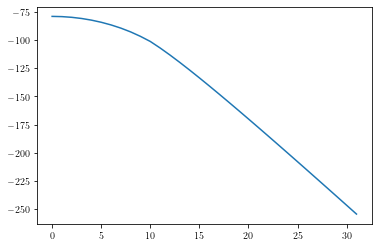

In [15]:
plt.plot(Energia)

Comparison

-121.94169597748738

In [30]:
from quspin.basis import spin_basis_1d 
h_x, h_y, h_z = 0.1, 0.9, 0.1  # Field in the different directions
J_xx, J_yy, J_zz = 1., 0.2, 1  # Strength of spin interactions
L=10
basis = spin_basis_1d(L,pauli=True) # Hilbert space-boson basis
J = [[J_zz,i,i+1] for i in range(L-1)] 
H=[[h_x,i] for i in range(L)]
static = [["zz",J],["x",H]]
dynamic=[]
H_ZZX = hamiltonian(static,dynamic,basis=basis)
E,V=H_ZZX.eigh()
#E_min=E[0]
print("Ground state energy",E[0])

Hermiticity check passed!


C:\Users\hgton\AppData\Local\Temp/ipykernel_26836/3492576549.py:10: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  H_ZZX = hamiltonian(static,dynamic,basis=basis)


Ground state energy -9.030021937875146


Drawing Figures 

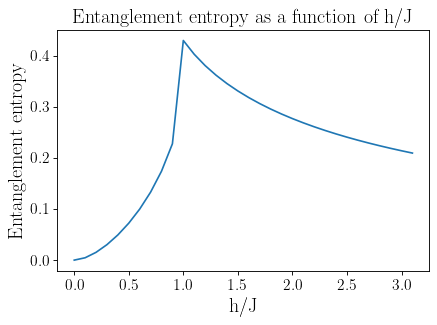

In [16]:
from matplotlib.ticker import MaxNLocator
import os
os.environ["PATH"] += ':/usr/local/texlive/2015/bin/x86_64-darwin'

x = np.arange(len(Entropiq))/10
#slx = np.arange(1,len(sluchaino)+1,1)
fig, ax = plt.subplots(dpi = 80)
#ax = fig.add_subplot(x,lamb[L//2][0:20])
#line, = ax.plot(x, lamb[L//2][0:t], c='b', marker='o')
#ax.set_yscale('log')
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel("h/J",fontsize=18)
plt.ylabel("Entanglement entropy",fontsize=18)
plt.plot(x, Entropiq)
#plt.scatter(slx,sluchaino, s=40, c='r', marker='o',label  = r"$|\psi_{random} \rangle$")
#plt.legend(fontsize = 14)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.tick_params(labelsize=14)
plt.title("Entanglement entropy as a function of h/J",fontsize=18)
plt.show()
#fig = plt.gcf()
#plt.savefig("nasheto.pdf")